# Nonlinear Head Timeseries

This notebook is meant to show some of the nonlinear head time series observed in the East of the Netherlands. These time series are obtained from Waterschap Rijn en IJssel for which we are grateful.

In [1]:
import glob
import numpy as np
import pandas as pd
import pastas as ps
import matplotlib.pyplot as plt

ps.show_versions()
ps.set_log_level('ERROR')

Python version: 3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:15:42) [MSC v.1916 64 bit (AMD64)]
Numpy version: 1.19.3
Scipy version: 1.7.3
Pandas version: 1.3.4
Pastas version: 0.20.0b
Matplotlib version: 3.5.0


# Plot Locations

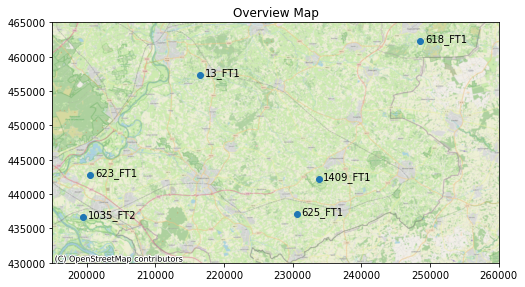

In [2]:
import pastastore as pst
df = pd.DataFrame({'x': {'1409_FT1': 233744.0,
                         '618_FT1': 248528.0,
                         '625_FT1': 230576.0,
                         '623_FT1': 200529.0,
                         '1035_FT2': 199440.0,
                         '13_FT1': 216490.0},
                   'y': {'1409_FT1': 442225.0,
                         '618_FT1': 462263.0,
                         '625_FT1': 437115.0,
                         '623_FT1': 442719.0,
                         '1035_FT2': 436620.0,
                         '13_FT1': 457352.0}})

fig = plt.figure(figsize=(8,6))
ax = plt.subplot(1,1,1)
ax.set_title('Overview Map')

ax.scatter(df['x'], df['y'])
for idx, row in df.iterrows(): 
    ax.text(row['x']+700, row['y'], idx)

ax.set_xlim(195000, 260000)
ax.set_ylim(430000, 465000)
pst.store.Maps.add_background_map(ax=ax)

# Read Head Timeseries

In [3]:
files = glob.glob('*.csv')

d = {}
names = []
for f in files:
    df = pd.read_csv(f, index_col=0, parse_dates=True)

    h = df.iloc[:, 0].dropna()
    p = df.iloc[:, 1].dropna()
    e = df.iloc[:, 2].dropna()

    d[h.name] = h
    d[f'p_{h.name}'] = p
    d[f'e_{h.name}'] = e

    names.append(h.name)

# Plot Head Timeseries

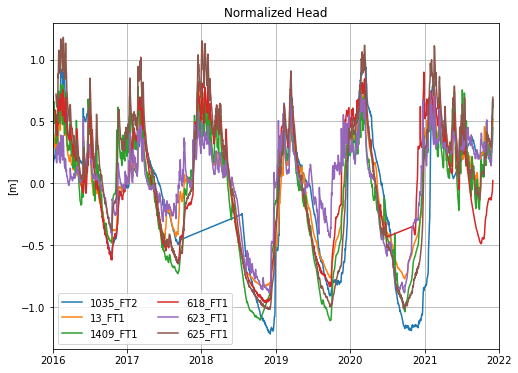

In [4]:
fig = plt.figure(figsize=(8,6))
ax2 = plt.subplot(1,1,1)
for ky in names:
    ho = d[ky]
    ax2.plot(ho - ho.mean(), label=ho.name)
ax2.set_xlim(pd.to_datetime(['2016', '2022']))
ax2.grid()
ax2.set_title('Normalized Head')
ax2.set_ylabel('[m]')
ax2.legend(ncol=2);
fig.savefig('Normalized Head Nonlinear Time Series')

# Create time series models

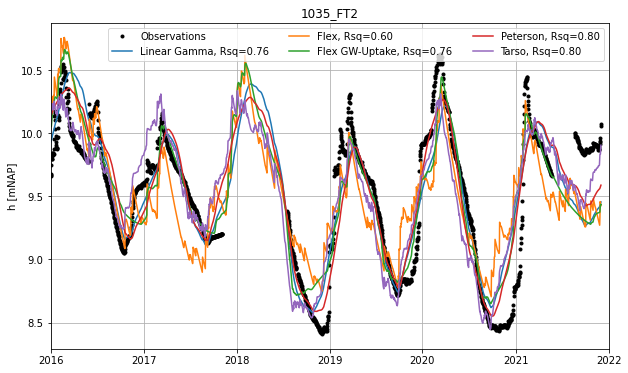

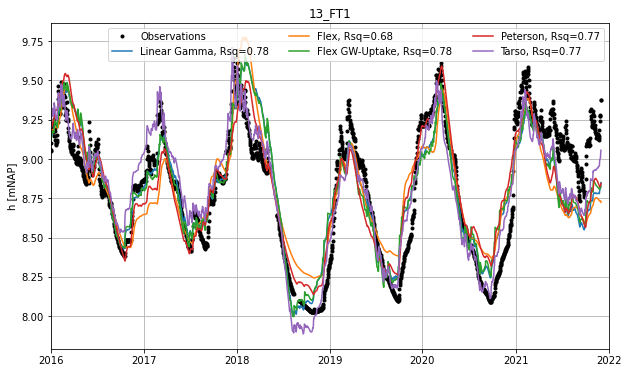

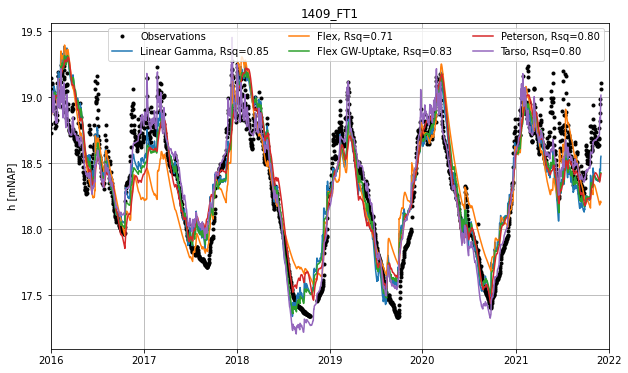

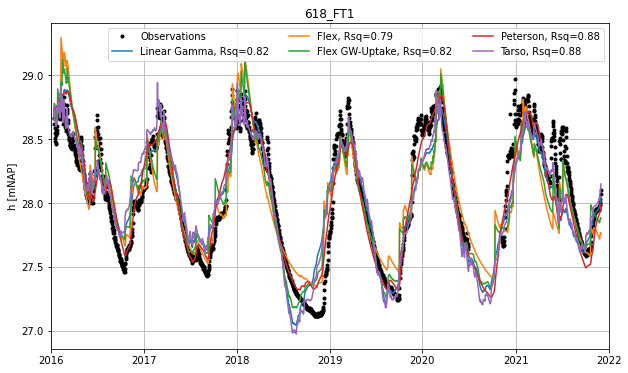

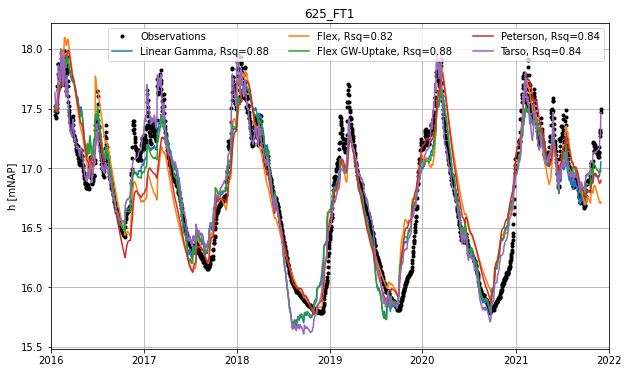

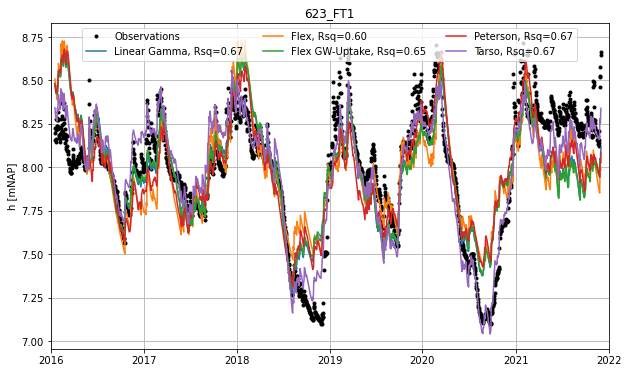

In [5]:
for mname in ['1035_FT2', '13_FT1', '1409_FT1', '618_FT1', '625_FT1', '623_FT1']:
    ml_lin = ps.Model(d[mname])
    sm = ps.RechargeModel(d[f'p_{mname}'], d[f'e_{mname}'], rfunc=ps.Gamma, recharge=ps.rch.Linear())
    ml_lin.add_stressmodel(sm)
    ml_lin.solve(noise=False, tmin='2016', report=False)

    ml_pet = ps.Model(d[mname])
    sm = ps.RechargeModel(d[f'p_{mname}'], d[f'e_{mname}'], recharge=ps.rch.Peterson())
    ml_pet.add_stressmodel(sm)
    ml_pet.solve(noise=False, tmin='2016', report=False)

    ml_flx = ps.Model(d[mname])
    sm = ps.RechargeModel(d[f'p_{mname}'], d[f'e_{mname}'], recharge=ps.rch.FlexModel())
    ml_flx.add_stressmodel(sm)
    ml_flx.solve(noise=False, tmin='2016', report=False)
    ml_flx.set_parameter('recharge_srmax', vary=False)
    ml_flx.solve(noise=False, tmin='2016', report=False, initial=False)

    ml_flxf = ps.Model(d[mname])
    sm = ps.RechargeModel(d[f'p_{mname}'], d[f'e_{mname}'], recharge=ps.rch.FlexModel(gw_uptake=True))
    ml_flxf.add_stressmodel(sm)
    ml_flxf.solve(noise=False, tmin='2016', report=False)
    # ml_flxf.set_parameter('recharge_srmax', vary=False)
    ml_flxf.solve(noise=False, tmin='2016', report=False, initial=False)

    ml_tarso = ps.Model(d[mname])
    sm = ps.TarsoModel(d[f'p_{mname}'], d[f'e_{mname}'], dmin=d[mname].min(), dmax=d[mname].max())
    ml_tarso.add_stressmodel(sm)
    ml_tarso.solve(noise=False, tmin='2016', report=False)

    fig = plt.figure(figsize=(10,6))
    ax = plt.subplot()
    ax.plot(d[mname], '.', color='k', label='Observations')
    ax.plot(ml_lin.simulate(), label=f'Linear Gamma, Rsq={ml_lin.stats.rsq():0.2f}')
    ax.plot(ml_flx.simulate(), label=f'Flex, Rsq={ml_flx.stats.rsq():0.2f}')
    ax.plot(ml_flxf.simulate(), label=f'Flex GW-Uptake, Rsq={ml_flxf.stats.rsq():0.2f}')
    ax.plot(ml_pet.simulate(), label=f'Peterson, Rsq={ml_pet.stats.rsq():0.2f}')
    ax.plot(ml_tarso.simulate(), label=f'Tarso, Rsq={ml_pet.stats.rsq():0.2f}')
    ax.set_title(mname)
    ax.set_ylabel('h [mNAP]')
    ax.legend(ncol=3)
    ax.grid()
    ax.set_xlim(pd.to_datetime(['2016', '2022']));

# Closer look at the parameters

In [6]:
ml_flx.parameters

,initial,name,optimal,pmin,pmax,vary,stderr
recharge_A,0.632527,recharge,0.632527,0.00001,65.216396,True,0.019095
recharge_a,94.409967,recharge,94.409967,0.01000,1000.000000,True,3.326515
recharge_srmax,30.499534,recharge,30.499534,0.00001,1000.000000,False,NaN
recharge_lp,0.250000,recharge,0.250000,0.00001,1.000000,False,NaN
recharge_ks,2169.575523,recharge,2169.575523,0.00001,10000.000000,True,3565.894950
recharge_gamma,5.122731,recharge,5.122731,0.00001,20.000000,True,1.494736
recharge_kv,1.000000,recharge,1.000000,0.25000,2.000000,False,NaN
recharge_simax,2.000000,recharge,2.000000,0.00000,10.000000,False,NaN
constant_d,6.954545,constant,6.954545,NaN,NaN,True,0.036324


In [7]:
ml_flxf.parameters

,initial,name,optimal,pmin,pmax,vary,stderr
recharge_A,0.443111,recharge,0.443113,0.00001,44.94368,True,1.668153e-02
recharge_a,95.833440,recharge,95.833807,0.01000,1000.00000,True,3.079684e+00
recharge_srmax,999.997813,recharge,999.997813,0.00001,1000.00000,True,1.376892e+04
recharge_lp,0.250000,recharge,0.250000,0.00001,1.00000,False,NaN
recharge_ks,1580.718815,recharge,1580.718815,0.00001,10000.00000,True,8.094756e-10
recharge_gamma,0.013926,recharge,0.013926,0.00001,20.00000,True,1.528657e-12
recharge_kv,1.000000,recharge,1.000000,0.25000,2.00000,False,NaN
recharge_simax,2.000000,recharge,2.000000,0.00000,10.00000,False,NaN
recharge_f,0.557065,recharge,0.557058,0.00000,1.00000,True,3.473697e-02
constant_d,7.482762,constant,7.482756,NaN,NaN,True,3.618872e-02


In [8]:
ml_pet.parameters

,initial,name,optimal,pmin,pmax,vary,stderr
recharge_A,0.435687,recharge,2.234286,0.00001,43.568712,True,0.467905
recharge_a,10.000000,recharge,97.618671,0.01000,1000.000000,True,3.722330
recharge_scap,1.000000,recharge,1.017309,0.00000,3.000000,True,0.036322
recharge_alpha,1.000000,recharge,1.211480,0.00000,1.500000,True,0.135809
recharge_ksat,1.000000,recharge,0.506331,0.00000,3.000000,True,0.082460
recharge_beta,0.500000,recharge,0.267072,0.00000,1.500000,True,0.143956
recharge_gamma,1.000000,recharge,1.164493,0.00000,2.000000,True,0.599759
constant_d,7.980999,constant,6.584543,NaN,NaN,True,0.064290


In [9]:
ml_lin.parameters

,initial,name,optimal,pmin,pmax,vary,stderr
recharge_A,0.204275,recharge,0.443663,0.00001,20.427509,True,0.014115
recharge_n,1.000000,recharge,1.022219,0.10000,100.000000,True,0.031379
recharge_a,10.000000,recharge,92.016561,0.01000,10000.000000,True,6.165609
recharge_f,-1.000000,recharge,-0.552597,-2.00000,0.000000,True,0.030069
constant_d,7.980999,constant,7.404319,NaN,NaN,True,0.035113


In [10]:
ml_tarso.parameters

,initial,name,optimal,pmin,pmax,vary,stderr
recharge_A0,0.204275,recharge,5.393657,0.00001,20.427509,True,1.301221
recharge_a0,10.000000,recharge,1000.000000,0.01000,1000.000000,True,249.291131
recharge_d0,7.923000,recharge,6.030820,NaN,NaN,True,19348.846484
recharge_A1,0.204275,recharge,0.077244,0.00001,20.427509,True,0.004496
recharge_a1,10.000000,recharge,13.704499,0.01000,1000.000000,True,1.024824
recharge_d1,8.335000,recharge,8.699537,7.09900,8.747000,True,19348.763832
recharge_f,-1.000000,recharge,-0.658005,-2.00000,0.000000,True,0.023120
constant_d,7.980999,constant,-0.553959,NaN,NaN,True,19348.764286
